In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr,gaussian_kde, chi2
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [4]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [5]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

def hessian(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    return np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])

In [6]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [7]:
corr1k05 = pd.read_csv("correlations1k05.csv")
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.5,2.0,0.499856,1.066526,0.094304,0.342680,0.018470,0.990632,0.039902,-0.000030,0.000035,0.000085,2.286137,1036.320311,790.965437,1.575158,342.357134,132.321577,2.121514,0.325300
1,0.5,2.0,0.542791,1.122486,0.100411,0.322249,0.017422,0.982336,0.039855,0.000043,0.000054,0.000060,1.096046,1098.984800,837.738600,1.171772,317.137989,130.292253,2.492943,0.359960
2,0.5,2.0,0.499646,0.968643,0.079728,0.322420,0.016576,1.045520,0.044054,-0.000006,0.000064,0.000078,1.582553,950.919797,680.074365,1.071991,317.321007,123.848657,2.012245,0.292922
3,0.5,2.0,0.491638,1.020213,0.082705,0.346461,0.017901,1.107595,0.047333,-0.000025,0.000043,0.000085,1.020314,1001.497759,715.038034,1.286969,341.026940,134.129429,1.952686,0.285709
4,0.5,2.0,0.416355,0.879178,0.070615,0.356148,0.019267,1.030536,0.042722,0.000003,0.000034,0.000067,1.407654,858.449778,607.417835,1.001392,354.627554,141.847676,1.475724,0.239396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.5,2.0,0.408480,0.864796,0.070334,0.359771,0.019942,0.990685,0.040502,0.000010,0.000159,0.000090,2.109520,849.811833,592.180581,1.330154,352.619310,160.779734,1.410982,0.236155
496,0.5,2.0,0.547311,1.133100,0.101418,0.325157,0.016577,0.985341,0.039241,0.000029,0.000209,0.000040,2.135617,1107.997350,839.448991,1.583431,317.979578,136.785981,2.493535,0.357288
497,0.5,2.0,0.546360,1.087630,0.100006,0.316871,0.016835,0.967212,0.039941,-0.000039,0.000004,0.000061,1.909262,1061.032487,807.226757,1.396022,312.643093,125.335446,2.442457,0.369578
498,0.5,2.0,0.449758,1.013840,0.087220,0.347692,0.018308,1.025623,0.042895,-0.000019,0.000238,0.000077,2.847650,988.805696,726.090174,1.230678,343.849577,140.950914,1.924139,0.296653


In [8]:
rho = 0.5
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k05.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],jac=hessian,args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    h = hessian([A1,A2,D],a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    var = -np.linalg.inv(h)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.3333333333333333 1.0 2.0
1.0430377206886525 0.04819049655415824 0.3401254503608964 0.014343357654168791 0.9939780431942347 0.03437104816318863 2.0666265037853475 0.14709260075352515
1.0970825931575525 0.0509440565996529 0.31978900460504517 0.013487755892393354 0.9787580914010171 0.03402215049642444 2.4306451358842134 0.16266558620692279
0.9504014922584343 0.043731909212220865 0.32013269531072963 0.013492640794999343 1.0427813790684106 0.03676923353932502 1.9687735935123665 0.14257222084625398
0.9998537300568452 0.045940687004154296 0.34395850358623625 0.014501909209525016 1.1055401033488257 0.03891294640087411 1.906902197887266 0.1424844244315019
0.8620743075222781 0.03924289491726916 0.3532712420662323 0.01492491380364671 1.0295442680012512 0.03582474838997593 1.4402617730221414 0.118428370319532
1.1289922074822625 0.052459464746756244 0.3250677291558873 0.013700170321124801 1.0152115552225964 0.03539170502667469 2.4730983921841427 0.16629662207987206
1.0230293034062952 0.047174

1.1630119018743321 0.05393587800301171 0.34757502299285836 0.014649045614248778 1.0840273654454038 0.037811969915811594 2.3460744441876327 0.16380486910955527
1.0370759099467393 0.048192606742056616 0.3006036206801331 0.012675130487912372 0.9328417024524465 0.03249559736979528 2.4499781060530643 0.1602485294805024
0.9722556087409377 0.044908194691514365 0.31199779843874914 0.013169941675863469 0.9266382804484553 0.03212421777691463 2.1162258631507913 0.14534870448155712
1.0224063199579112 0.047396645354787485 0.3099698553218376 0.013039180179148797 0.9869962435784126 0.03453954997443781 2.298405643014416 0.15546396668233822
1.1559331998785825 0.053572324361581436 0.3545746962232975 0.014982670367783538 0.9914191595623725 0.034027544048531456 2.260055531855043 0.1576270471807478
1.1362782069975546 0.05270828719232234 0.34271873378239387 0.014417398187522978 1.0405987662005594 0.03611696347548429 2.315483208218854 0.16023014502997032
0.9560136585730045 0.04400727038419544 0.3336430363276

1.020418975884328 0.04720848680548811 0.32148594546486786 0.013538376684080441 0.9823684315923346 0.03417724433032902 2.174070251838863 0.15035497753646507
0.948548946694892 0.043640951485305016 0.3307836782227083 0.013961643462873792 0.9752483749585682 0.03383565242657193 1.86758086672057 0.13655338975149411
0.8536827383522458 0.03910460397291924 0.3111064647552042 0.01313883783966077 0.9738127166053785 0.03418970707044663 1.7440212115938212 0.12954910260827174
0.9713686826124361 0.04495861506793157 0.30132869878570256 0.012686220210592944 0.9607649660321109 0.03365802790707847 2.223618216674573 0.1504891479652368
0.8809188062307188 0.040316390019615074 0.33725607680175035 0.01426563706305659 0.9604165562965722 0.033236310671470336 1.612017593825449 0.12463136436597216
0.9251545333537482 0.042588311925045114 0.3128260464105618 0.013205693059511785 0.9413140225693308 0.03274495389240437 1.957408898552997 0.13847919851433646
0.954174195019984 0.04385673574158908 0.3243001453421407 0.013

0.9923171816331993 0.045717872822064 0.33622220786737234 0.01414879717307082 1.0408670745973323 0.036350057899036226 1.9513731050883854 0.1422529183675844
1.0091481592451683 0.046589164889558915 0.32875333160631554 0.01388518842934786 0.949548724465272 0.03278768102366794 2.0696210873799763 0.14526510131346562
0.869594545691603 0.039740318262991715 0.3376201631812955 0.014290664496957792 0.9421578229969005 0.0325150683710104 1.5756593963395709 0.12239292824685474
1.0094746558542909 0.04652423569075016 0.3376933917689178 0.014277947404846279 0.9667432139655022 0.033364763713144466 1.9893230974003488 0.142749171927554
1.1111274368087425 0.05161657211970851 0.33208633627265305 0.014005470707685 0.94809818843283 0.032609327245260486 2.345899290166738 0.1584752986078364
0.9738671156068757 0.04480884057298117 0.3309017026334434 0.013925664064943553 1.0675980595964663 0.03756508444109501 1.9430707302394203 0.1422926312343044
0.9799318157385383 0.04522620948732334 0.3248292832054081 0.01366601

1.0299990336939047 0.047648670099679276 0.32179814368366705 0.013563947474865784 0.984172999326881 0.03424880141650378 2.200761265753015 0.1518611506705508
1.112555406692033 0.05168747021068501 0.3378134911617632 0.014253191855975176 0.9840907331636191 0.03396967730661359 2.293401346600695 0.1579886372656211
1.0944922830876436 0.050784572743162504 0.3253019313461916 0.013683244491234127 1.087833369780074 0.03839049018447869 2.364542837352131 0.16331450885051038
0.9903683719170033 0.04562289932698214 0.3351236138798138 0.014150035724179416 0.9795364378447743 0.033913992055525255 1.955233027154516 0.14112823379352976
1.1006447077513846 0.05091707840984013 0.34540623335852316 0.014615264295864336 0.9713779293359154 0.03339640619563792 2.186522423319855 0.1530722773903858
0.9450346993017302 0.04365969700421499 0.3001701620892845 0.012609433337395955 1.0338340493863185 0.03673750733000339 2.1483299096884694 0.14919416681814213
0.9809970688076095 0.045149925295748475 0.3344173728686466 0.014

1.0164690593483092 0.046833137707212195 0.3406866773631335 0.014376234856611988 1.0569951180254993 0.03695302838364807 1.9835891066114921 0.1450806034843456
0.9264259350087128 0.04234175821286795 0.3609356010217568 0.0152536055013246 1.0335952659029009 0.03580857108374225 1.5667347094222188 0.1251901143302012
0.9710000756437236 0.04488771269398278 0.30277522354568315 0.012763712062557287 0.9854561527873631 0.03467279245721128 2.206999781133735 0.15105236022036045
0.9076377801476944 0.0418363683168962 0.31178951359095175 0.013143596214036714 0.9525284231237492 0.03322377445486356 1.9110593544158065 0.1367148806454664
0.9801895609244174 0.045129626255861297 0.33699146825500326 0.014242004625570232 0.9596133412790577 0.03310753120005336 1.908648002277324 0.13858670415157476
1.0363556485309984 0.048036908799935864 0.31014816193710415 0.013072642546984157 1.0815304805285118 0.0385180563810799 2.3414857017310453 0.16176891457531842
1.0022061544513374 0.046333219312115516 0.3200033328881551 0

1.0284022613187052 0.04757799743665356 0.31812196360321654 0.013399306360173332 1.028268819362901 0.03611456160297225 2.2327295156564504 0.15460737801211194
1.113663665881141 0.05133545601610205 0.38948432589021736 0.016479311565074223 1.0933014225991473 0.03766769237942223 1.859328583597599 0.14284902945614214
1.1169699905407946 0.05185203346219207 0.32518725445955216 0.013709575870333461 1.0459393071063694 0.03666371923711274 2.43485168998137 0.16568984252464256
1.0306968168252153 0.047565783561717326 0.3374235981349344 0.014255124166090347 0.9819996881809674 0.03395581019890956 2.0546079839177214 0.14623530462060907
1.220849973945698 0.05679370467526126 0.3488557757412627 0.014757460382517412 0.9967118421245273 0.03429034274797604 2.4995836641993017 0.1694646285538301
1.0419339766469937 0.04798528760271339 0.34926254036414667 0.014749472026270602 1.0458855046403939 0.03634965167884736 1.9832399877772657 0.14519128004179221
0.9615297022280417 0.04423520629907305 0.33503994758221334 0

0.8853568430956236 0.040616861907151434 0.31157256999488037 0.013140969497322103 1.029764710410304 0.03647064952413035 1.841575056206557 0.13575851217411483
1.0128593437979012 0.04656383813969465 0.3527410108478447 0.01493244647742691 1.0015751071859713 0.034566770002988065 1.8713966129523834 0.13913273216483843
0.9935062123509649 0.04568208463430373 0.34074636543025866 0.01438279232802056 1.0378317032470223 0.036189156774717506 1.915676623862062 0.1411129502939506
0.9750048463835412 0.044973457471825434 0.3174813183614523 0.013382577994514255 1.003555491395701 0.035160230712582514 2.0710621066323616 0.14608185695001527
1.0033952283295688 0.04626531725402608 0.33081890118792856 0.013928873069907406 1.0354872688095533 0.03621212193637232 2.033064993343803 0.14578774408467493
0.9788073313265961 0.044950151726462294 0.34802038092241466 0.014692580106589293 1.0213168170449225 0.035425349156053464 1.8125000286831041 0.13607051789965446
0.8765340455233527 0.04022158095478679 0.30900573927695

In [9]:
corr1k05['A1'] = A1_list
corr1k05['A2'] = A2_list
corr1k05['dA1'] = dA1_list
corr1k05['dA2'] = dA2_list
corr1k05['D'] = D_list
corr1k05['dD'] = dD_list
corr1k05['dA1dA2'] = dA1dA2_list
corr1k05['dA1dD'] = dA1dD_list
corr1k05['dA2dD'] = dA2dD_list
corr1k05['C'] = C_list
corr1k05['dC'] = dC_list
corr1k05['tau1'] = tau1_list
corr1k05['tau2'] = tau2_list
corr1k05['dtau1'] = dtau1_list
corr1k05['dtau2'] = dtau2_list

In [10]:
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.5,2.0,0.499856,1.066526,0.094304,0.342680,0.018470,0.990632,0.039902,-0.000030,...,0.034371,0.000195,0.001029,0.000223,2.066627,0.147093,1.049357,0.342186,0.293243,0.294697
1,0.5,2.0,0.542791,1.122486,0.100411,0.322249,0.017422,0.982336,0.039855,0.000043,...,0.034022,0.000189,0.001091,0.000201,2.430645,0.162666,1.120892,0.326729,0.310683,0.312354
2,0.5,2.0,0.499646,0.968643,0.079728,0.322420,0.016576,1.045520,0.044054,-0.000006,...,0.036769,0.000155,0.000996,0.000210,1.968774,0.142572,0.911410,0.306999,0.259752,0.261016
3,0.5,2.0,0.491638,1.020213,0.082705,0.346461,0.017901,1.107595,0.047333,-0.000025,...,0.038913,0.000176,0.001105,0.000241,1.906902,0.142484,0.904403,0.311123,0.250623,0.251896
4,0.5,2.0,0.416355,0.879178,0.070615,0.356148,0.019267,1.030536,0.042722,0.000003,...,0.035825,0.000162,0.000851,0.000244,1.440262,0.118428,0.837336,0.343134,0.245045,0.246023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.5,2.0,0.408480,0.864796,0.070334,0.359771,0.019942,0.990685,0.040502,0.000010,...,0.034185,0.000164,0.000801,0.000240,1.380629,0.115369,0.859120,0.360879,0.254181,0.255149
496,0.5,2.0,0.547311,1.133100,0.101418,0.325157,0.016577,0.985341,0.039241,0.000029,...,0.034150,0.000193,0.001104,0.000204,2.422939,0.163085,1.125528,0.328819,0.310902,0.312584
497,0.5,2.0,0.546360,1.087630,0.100006,0.316871,0.016835,0.967212,0.039941,-0.000039,...,0.033649,0.000179,0.001041,0.000195,2.377257,0.159273,1.098437,0.325245,0.308070,0.309679
498,0.5,2.0,0.449758,1.013840,0.087220,0.347692,0.018308,1.025623,0.042895,-0.000019,...,0.035645,0.000184,0.001005,0.000232,1.876314,0.139264,0.967600,0.336403,0.272325,0.273626


In [33]:
# display statistics
print(corr1k05['A1'].mean(),corr1k05['A1'].std(),corr1k05['dA1'].mean(),corr1k05['dA1'].std())
print(corr1k05['a1'].mean(),corr1k05['a1'].std(),corr1k05['da1'].mean(),corr1k05['da1'].std())
print(corr1k05['A2'].mean(),corr1k05['A2'].std(),corr1k05['dA2'].mean(),corr1k05['dA2'].std())
print(corr1k05['a2'].mean(),corr1k05['a2'].std(),corr1k05['da2'].mean(),corr1k05['da2'].std())
print(corr1k05['C'].mean(),corr1k05['C'].std(),corr1k05['dC'].mean(),corr1k05['dC'].std())
print(corr1k05['c'].mean(),corr1k05['c'].std(),corr1k05['dc'].mean(),corr1k05['dc'].std())

1.0011002540472573 0.08241525835122637 0.04615625237656327 0.004029784882768329
1.022721081027039 0.08597734740751412 0.08838274789220267 0.011439265012152557
0.33429139700779775 0.018109289422939132 0.014113937093481283 0.0007862972675411842
0.33674347085225104 0.018481246928205568 0.017891686370492883 0.0013093884293063416
2.0030293661282004 0.2918338760335431 0.1440624616252482 0.01342765477477542
2.054366592271747 0.30347743523970155 0.30936585554054535 0.03993081449567026


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


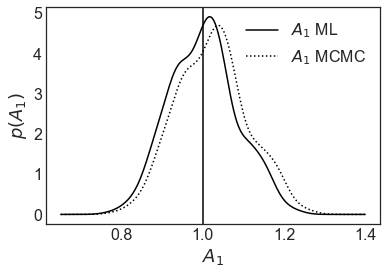

In [12]:
plt.figure(facecolor="white")
xs = np.linspace(0.65,1.4,200)
densityA1 = gaussian_kde(corr1k05['A1'])
densitya1 = gaussian_kde(corr1k05['a1'])
plt.plot(xs,densityA1(xs),"k-",label=r"$A_{1}$ ML")
plt.plot(xs,densitya1(xs),"k:",label=r"$A_{1}$ MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A_1$")
plt.ylabel(r"$p(A_{1})$")
plt.savefig("A1kde05.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


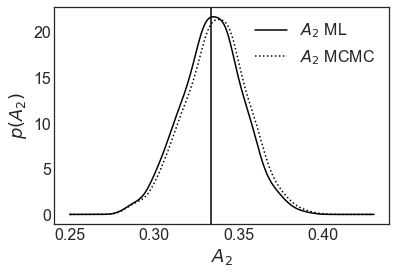

In [13]:
plt.figure(facecolor="white")
xs = np.linspace(0.25,0.43,200)
densityA2 = gaussian_kde(corr1k05['A2'])
densitya2 = gaussian_kde(corr1k05['a2'])
plt.plot(xs,densityA2(xs),"k-",label=r"$A_{2}$ ML")
plt.plot(xs,densitya2(xs),"k:",label=r"$A_{2}$ MCMC")
plt.axvline(x=0.3333,color="k")
plt.legend()
plt.xlabel(r"$A_2$")
plt.ylabel(r"$p(A_{2})$")
plt.savefig("A2kde05.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [14]:
# display statistics
print(corr1k05['dA1dA2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['dA1dD'].mean(),corr1k05['dA2dD'].mean())
print(corr1k05['da1da2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['da1dd'].mean(),corr1k05['dasdd'].mean())

0.00017937105182656276 2.2416161705949636e-05 0.0010019130752889284 0.0002189101772480943
3.222752498210501e-06 2.2416161705949636e-05 9.360270817786626e-05 6.750408235903608e-05


(array([ 1.,  0.,  1.,  3.,  3.,  5., 16., 22., 18., 22., 44., 29., 38.,
        34., 49., 35., 30., 29., 25., 21., 13., 13., 13.,  8., 14.,  8.,
         3.,  2.,  0.,  1.]),
 array([0.05599813, 0.05822307, 0.06044801, 0.06267295, 0.0648979 ,
        0.06712284, 0.06934778, 0.07157272, 0.07379766, 0.0760226 ,
        0.07824754, 0.08047248, 0.08269742, 0.08492236, 0.0871473 ,
        0.08937224, 0.09159719, 0.09382213, 0.09604707, 0.09827201,
        0.10049695, 0.10272189, 0.10494683, 0.10717177, 0.10939671,
        0.11162165, 0.11384659, 0.11607154, 0.11829648, 0.12052142,
        0.12274636]),
 <BarContainer object of 30 artists>)

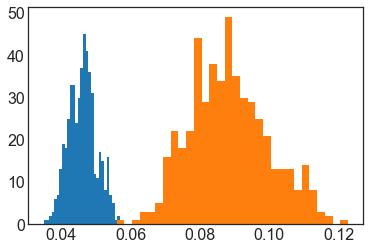

In [15]:
plt.hist(corr1k05['dA1'],bins=30)
plt.hist(corr1k05['da1'],bins=30)

(array([ 3.,  4.,  5.,  9.,  3.,  9., 10., 15., 22., 22., 30., 38., 35.,
        31., 43., 30., 33., 31., 31., 20., 19.,  8., 14., 12.,  5.,  5.,
         5.,  3.,  2.,  3.]),
 array([0.01450614, 0.01474141, 0.01497668, 0.01521195, 0.01544722,
        0.01568249, 0.01591776, 0.01615302, 0.01638829, 0.01662356,
        0.01685883, 0.0170941 , 0.01732937, 0.01756464, 0.0177999 ,
        0.01803517, 0.01827044, 0.01850571, 0.01874098, 0.01897625,
        0.01921152, 0.01944679, 0.01968205, 0.01991732, 0.02015259,
        0.02038786, 0.02062313, 0.0208584 , 0.02109367, 0.02132893,
        0.0215642 ]),
 <BarContainer object of 30 artists>)

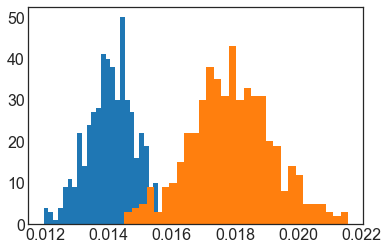

In [16]:
plt.hist(corr1k05['dA2'],bins=30)
plt.hist(corr1k05['da2'],bins=30)

In [17]:
print(corr1k05['A1'].std()/corr1k05['dA1'].mean())
print(corr1k05['A2'].std()/corr1k05['dA2'].mean())
print(corr1k05['D'].std()/corr1k05['dD'].mean())
print(corr1k05['dA1dA2'].mean()/corr1k05['da1da2'].mean())
print(corr1k05['dA1dD'].mean()/corr1k05['da1dd'].mean())
print(corr1k05['dA2dD'].mean()/corr1k05['dasdd'].mean())

1.7855708405189827
1.2830785133159732
1.2627363286865256
55.65771865079996
10.70388982106231
3.2429176073199524


(array([ 2.,  6.,  5.,  6., 11., 22., 15., 23., 30., 34., 26., 42., 42.,
        34., 50., 27., 27., 28., 20., 17.,  7., 11.,  5.,  6.,  2.,  0.,
         1.,  0.,  0.,  1.]),
 array([-8.39971723e-05, -7.71001886e-05, -7.02032050e-05, -6.33062213e-05,
        -5.64092376e-05, -4.95122540e-05, -4.26152703e-05, -3.57182866e-05,
        -2.88213029e-05, -2.19243193e-05, -1.50273356e-05, -8.13035193e-06,
        -1.23336826e-06,  5.66361541e-06,  1.25605991e-05,  1.94575827e-05,
         2.63545664e-05,  3.32515501e-05,  4.01485338e-05,  4.70455174e-05,
         5.39425011e-05,  6.08394848e-05,  6.77364684e-05,  7.46334521e-05,
         8.15304358e-05,  8.84274195e-05,  9.53244031e-05,  1.02221387e-04,
         1.09118370e-04,  1.16015354e-04,  1.22912338e-04]),
 <BarContainer object of 30 artists>)

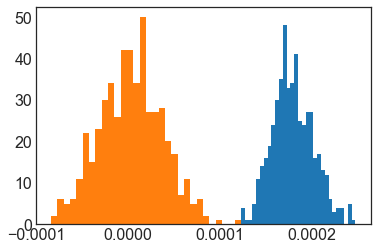

In [18]:
plt.hist(corr1k05['dA1dA2'],bins=30)
plt.hist(corr1k05['da1da2'],bins=30)

(array([ 1.,  3.,  2.,  1.,  8.,  9., 10., 18., 17., 24., 25., 43., 29.,
        33., 21., 31., 36., 37., 30., 31., 18., 10., 20.,  8., 14.,  7.,
         4.,  4.,  2.,  4.]),
 array([-1.14554256e-04, -1.00774023e-04, -8.69937895e-05, -7.32135565e-05,
        -5.94333234e-05, -4.56530904e-05, -3.18728573e-05, -1.80926243e-05,
        -4.31239126e-06,  9.46784179e-06,  2.32480748e-05,  3.70283079e-05,
         5.08085409e-05,  6.45887740e-05,  7.83690070e-05,  9.21492400e-05,
         1.05929473e-04,  1.19709706e-04,  1.33489939e-04,  1.47270172e-04,
         1.61050405e-04,  1.74830638e-04,  1.88610871e-04,  2.02391104e-04,
         2.16171337e-04,  2.29951570e-04,  2.43731804e-04,  2.57512037e-04,
         2.71292270e-04,  2.85072503e-04,  2.98852736e-04]),
 <BarContainer object of 30 artists>)

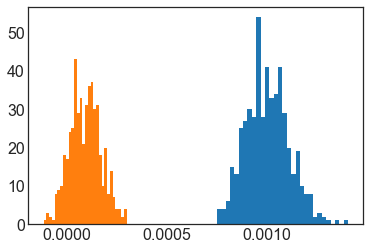

In [19]:
plt.hist(corr1k05['dA1dD'],bins=30)
plt.hist(corr1k05['da1dd'],bins=30)

(array([ 1.,  4.,  7.,  6.,  9., 14., 14., 25., 33., 42., 46., 43., 49.,
        52., 35., 33., 20., 13., 14., 14., 12.,  5.,  3.,  4.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([2.24570230e-05, 2.61538454e-05, 2.98506679e-05, 3.35474903e-05,
        3.72443127e-05, 4.09411351e-05, 4.46379575e-05, 4.83347799e-05,
        5.20316023e-05, 5.57284247e-05, 5.94252471e-05, 6.31220695e-05,
        6.68188919e-05, 7.05157143e-05, 7.42125367e-05, 7.79093591e-05,
        8.16061815e-05, 8.53030039e-05, 8.89998263e-05, 9.26966487e-05,
        9.63934711e-05, 1.00090294e-04, 1.03787116e-04, 1.07483938e-04,
        1.11180761e-04, 1.14877583e-04, 1.18574406e-04, 1.22271228e-04,
        1.25968050e-04, 1.29664873e-04, 1.33361695e-04]),
 <BarContainer object of 30 artists>)

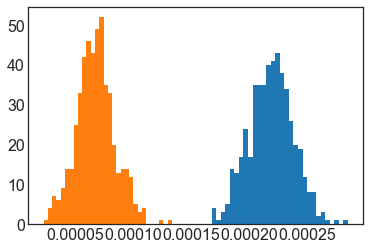

In [20]:
plt.hist(corr1k05['dA2dD'],bins=30)
plt.hist(corr1k05['dasdd'],bins=30)

[0.34264275 0.01587254]
factor of underestimation:  2.9184916704323416


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


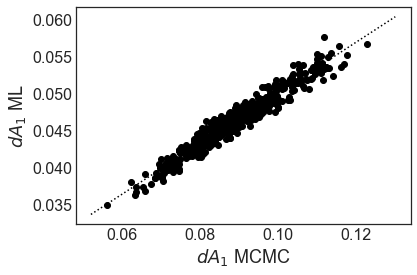

In [21]:
p1 = np.polyfit(corr1k05['da1'],corr1k05['dA1'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da1 = np.linspace(0.052,0.13,200)
dA1 = p1[0]*da1 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k05['da1'],corr1k05['dA1'],color="k")
plt.plot(da1,dA1,"k:")
plt.xlabel(r"$dA_1$ MCMC")
plt.ylabel(r"$dA_{1}$ ML")
plt.savefig("dA1corrkde05.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

[0.57570886 0.00381353]
factor of underestimation:  1.736989087788872


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


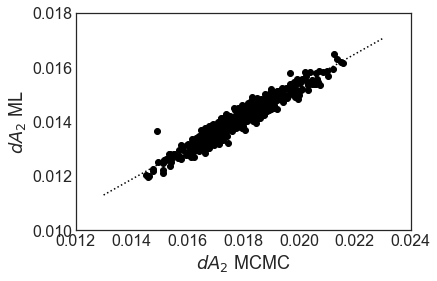

In [22]:
p1 = np.polyfit(corr1k05['da2'],corr1k05['dA2'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da2 = np.linspace(0.013,0.023,200)
dA2 = p1[0]*da2 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k05['da2'],corr1k05['dA2'],color="k")
plt.plot(da2,dA2,"k:")
plt.xlabel(r"$dA_2$ MCMC")
plt.ylabel(r"$dA_{2}$ ML")
plt.xlim((0.012,0.024))
plt.ylim((0.01,0.018))
plt.savefig("dA2corrkde05.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [23]:
corr1k05['dA2'].min()

0.011961607890288951

[0.32170841 0.04453686]
factor of underestimation:  3.108404864644259


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


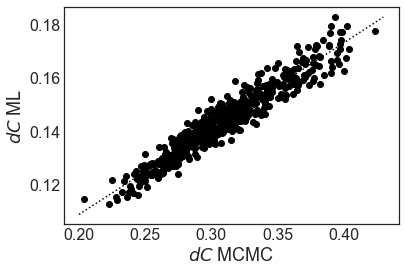

In [32]:
p1 = np.polyfit(corr1k05['dc'],corr1k05['dC'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
dc = np.linspace(0.2,0.43,200)
dC = p1[0]*dc + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k05['dc'],corr1k05['dC'],color="k")
plt.plot(dc,dC,"k:")
plt.xlabel(r"$dC$ MCMC")
plt.ylabel(r"$dC$ ML")
#plt.xlim((0.012,0.024))
#plt.ylim((0.01,0.018))
plt.savefig("dCcorrkde05.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")